In [2]:
import numpy as np 
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import sklearn 

In [27]:
def merit(x,y,correlation="pearson"):
    # x=matrix of features 
    # y=matrix (or vector) of targets 
    # correlation="pearson" or "spearman"
    r_xx=0
    r_xy=0
    for i in range(x.shape[1]):
        for v in range(i+1,x.shape[1]):
            xi = x.iloc[:,i]
            xv = x.iloc[:,v]
            if correlation=="pearson": 
                correlation_coefficient, p_value = scipy.stats.pearsonr(xi,xv)
                r_xx += correlation_coefficient
            if correlation=="spearman": 
                correlation_coefficient, p_value = scipy.stats.spearmanr(xi,xv)
                r_xx += correlation_coefficient

    for i in range(x.shape[1]):
        xi = x.iloc[:,i]
        yi = y.iloc[:,0]
        if correlation=="pearson": 
            correlation_coefficient, p_value = scipy.stats.pearsonr(xi,yi)
            r_xy += correlation_coefficient
        if correlation=="spearman": 
            correlation_coefficient, p_value = scipy.stats.spearmanr(xi,yi)
            r_xy += correlation_coefficient
            
    k = x.shape[1]
    if k == 1:
        r_xx_avg =0
        r_xy_avg = r_xy/(k)
    else:
        r_xx_avg = r_xx/((k-1)*k/2)
        r_xy_avg = r_xy/(k)

    return (k*np.absolute(r_xy_avg)/(np.sqrt(k+k*(k-1)*np.absolute(r_xx_avg))))

In [10]:
cardio = pd.read_csv("../Data/01-modified-data/cardiovascular_numeric_final.csv")

cardio = cardio.drop(columns=['Unnamed: 0', 'id'])
cardio.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,2,168,62,110,80,1,1,0,0,1,0,21.97
1,55,1,156,85,140,90,3,1,0,0,1,1,34.93
2,52,1,165,64,130,70,3,1,0,0,0,1,23.51
3,48,2,169,82,150,100,1,1,0,0,1,1,28.71
4,48,1,156,56,100,60,1,1,0,0,0,0,23.01


In [38]:
import itertools

def maximize_CFS(x,y):
    list1 = [*range(1,x.shape[1]+1)]; #print(list1)
    m = float('-inf')
    for L in range(1,len(list1)):
        for subset in itertools.combinations(list1, L):
            subset_l = list(subset)
            subset_l = [x - 1 for x in subset_l]
            x_subset = x.iloc[:,subset_l]
            m_temp = merit(x_subset,y,correlation="spearman")
            if m_temp > m:
                print("found new max: ", m_temp)
                print("optimal features = ", subset_l)
                m= m_temp
                opt_set = x_subset

    return opt_set

def maximize_CFS_2(x,y):
    list1 = [*range(1,x.shape[1]+1)]; #print(list1)
    m = float('-inf')
    for L in range(1,len(list1)):
        for subset in itertools.combinations(list1, L):
            subset_l = list(subset)
            subset_l = [x - 1 for x in subset_l]
            x_subset = x.iloc[:,subset_l]
            m_temp = merit(x_subset,y,correlation="spearman")
            if m_temp > m:
                print("found new max: ", m_temp)
                subset_l_print = [x + 6 for x in subset_l]
                print("optimal features = ", subset_l_print)
                m= m_temp
                opt_set = x_subset

    return opt_set

In [23]:
def explore_data(x,y):

    #PRINT SHAPE
    print(x.shape)
    print(y.shape)

    #COMPUTE MERIT 
    # print("merit =",merit(x,y,correlation="spearman")); 
    print("merit =",merit(x,y,correlation="spearman"))

    # #PLOT
    # if (iplot):
    #     sns.pairplot(pd.DataFrame(np.hstack((x,y.reshape(y.shape[0],1)))))
    #     plt.show()

In [31]:
cardio_x = cardio.drop(columns=['cardio'])
cardio_x_1 = cardio_x.iloc[:,0:6]
cardio_x_2 = cardio_x.iloc[:,6:12]
cardio_y = cardio[['cardio']]

In [28]:
explore_data(cardio_x,cardio_y)

(64806, 12)
(64806, 1)
merit = 0.3148619450034282


In [33]:
x_opt_1=maximize_CFS(cardio_x_1,cardio_y) #using merit find the most revelent columns (1st 6)

found new max:  0.24118366917520198
optimal features =  [0]
found new max:  0.44305965281952503
optimal features =  [4]
found new max:  0.4496408170195329
optimal features =  [0, 4, 5]


In [39]:
x_opt_2=maximize_CFS_2(cardio_x_2,cardio_y) #rest of (6)

found new max:  0.2107372715369121
optimal features =  [6]
found new max:  0.2586790918689096
optimal features =  [6, 11]


In [40]:
cardio_x_new = cardio_x.iloc[:,[0,4,5,6,11]] #best subset
explore_data(cardio_x_new,cardio_y)

(64806, 5)
(64806, 1)
merit = 0.4562044278371533


In [41]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [47]:
X_train, X_test, y_train, y_test = train_test_split(cardio_x_new, cardio_y, test_size=0.2, random_state=20)
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train,y_train)
y_pred_test = nb_classifier.predict(X_test)
y_pred_train = nb_classifier.predict(X_train)

/Users/xueningyang/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
def get_metrics(true, preds):
    """
    Takes gold labels and predictions to compute performance metrics
    :param true: array-like object
    :param preds: array-like object
    :return: a tuple of various performance metrics
    """
    accuracy = metrics.accuracy_score(true['cardio'],preds)
    f1_score = metrics.f1_score(true['cardio'],preds)
    conf_matrix = metrics.confusion_matrix(true['cardio'],preds)

    return accuracy, f1_score, conf_matrix

In [50]:
def plot_confusion_matrix(conf_matrix_data, labels, data="train"):
    """
    Takes as input confusion matrix data from get_metrics() and prints out a
    confusion matrix
    :param conf_matrix_data:
    :return: None
    """
    if data == "train":
        plt.title("Training Confusion Matrix")
    else:
        plt.title("Test Confusion Matrix")
    axis = sns.heatmap(conf_matrix_data,annot=True,fmt="d")
    axis.set_xticklabels(labels)
    axis.set_yticklabels(labels)
    axis.set_xlabel("predicted")
    axis.set_ylabel("true")
    plt.show()
    return

In [51]:
acc_train, f1_train, conf_train = get_metrics(y_train, y_pred_train)
acc_test, f1_test, conf_test = get_metrics(y_test, y_pred_test)
print("Training Accuracy:", acc_train)
print("Test Accuracy:", acc_test)
print("Training F1 Score:", f1_train)
print("Test F1 Score:", f1_test)

Training Accuracy: 0.6054123910192115
Test Accuracy: 0.598518747106928
Training F1 Score: 0.5276719540070651
Test F1 Score: 0.5287085672885347


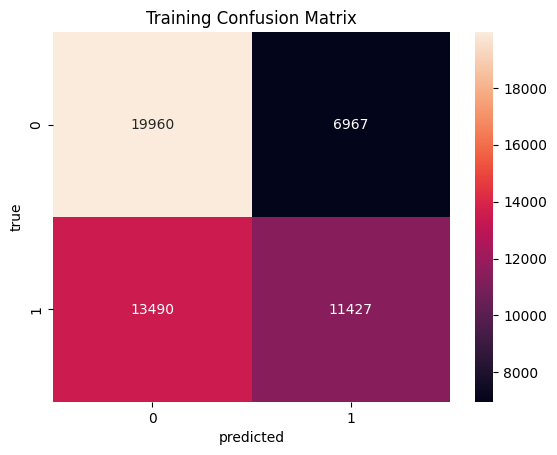

In [52]:
plot_confusion_matrix(conf_train, [0, 1],data="train")

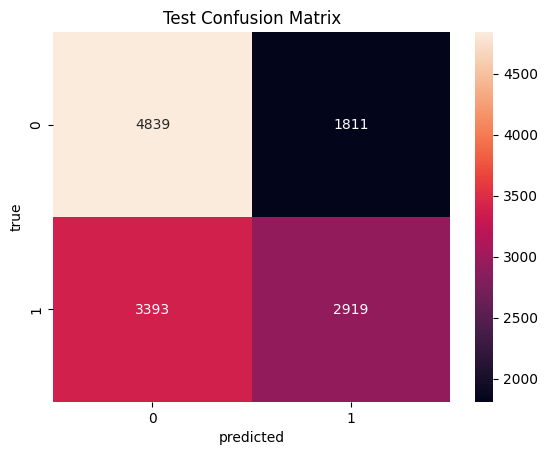

In [53]:
plot_confusion_matrix(conf_test, [0, 1],data="test")